In [1]:
# Show plots inline, and load main getdist plot module and samples class
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pylab as mplot
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True



%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.figsize'] = (16.,8.)
#import config

from chainconsumer import ChainConsumer


GetDist Version: 1.3.4, Matplotlib version: 3.1.1


In [2]:
def get_names(filename):
    """
    Function to obtain the names of the parameters of your chain
    """
    data = np.genfromtxt(filename, names=True)
    names = np.array(data.dtype.names)
    #print(names)
    #print(len(names))
    return names

def get_indices(filename, list_vars):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    return indices

def get_om_s8(filename):
    # might be useful later..
    data = np.loadtxt(filename)
    nsample = get_nsample(filename)
    data_params = []
    data_params.append([data[-nsample:,0], data[-nsample:,-3]*(data[-nsample:,0]/0.3)**(0.5)])
    data_params = np.array(data_params[0][:]).T
    weights = data[-nsample:,-1]
    return data_params, weights

def compute_s8(om, sigma_8):
    return sigma_8*(om/0.3)**0.5

In [131]:
dir = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/'
dir2 = '../../data_vectors/cosmodc2/2022/star_sample/Sep14/chains/'
nlbins = 5

name_plots = 'wcdm-srd-y3-gs-cosmodc2-comparison'

chainfile_0 = dir + 'gaussian_sims_3x2pt_fourier_w0-wa.txt'
name_0 = r'Gaussian sims TXPipe + FireCrown' 

chainfile_1  = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/LSST_DESC_SRD_v1_release/chains/indiv_joint_probes/Y1_3x2.txt'
name_1 = 'Forecasted in SRD'

chainfile_2  = '../../data_vectors/gaussian_sims/071222/area12300/July14/chains/desy3_official_chains/chain_2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits.scales-ml_3x2pt_8_6_0.5_v0.40.ini.d3_w0wa_nla_realy3dat.txt'
name_2 = 'DES Y3'

chainfile_3 = dir2 + 'cosmodc2_3x2pt_fourier_w0-wa.txt'
name_3 = r'$\textsc{CosmoDC2}$'

chainfile_4 =  dir+ 'prior_3x2pt_wcdm.txt'
name_4 = r'Prior (for this work)'

colors = ["#474747", "#6992C2", "#C0E0FF", "#FADA77", "#FEB580", 'tomato', 'firebrick']


In [132]:
chain_0 = np.loadtxt(chainfile_0)
chain_1 = np.loadtxt(chainfile_1)
chain_2 = np.loadtxt(chainfile_2)
chain_3 = np.loadtxt(chainfile_3)
chain_4 = np.loadtxt(chainfile_4)
print(len(chain_0))
print(len(chain_1))
print(len(chain_4))

256640
640000
20000


In [93]:
get_names(chainfile_0), get_names(chainfile_1), get_names(chainfile_2),  get_names(chainfile_3)

(array(['cosmological_parametersomega_c', 'cosmological_parametersomega_b',
        'cosmological_parametersn_s', 'cosmological_parametersa_s',
        'cosmological_parametersh0', 'cosmological_parametersw',
        'cosmological_parameterswa', 'firecrown_two_pointia_bias',
        'firecrown_two_pointalphaz',
        'firecrown_two_pointsource_0_mult_bias',
        'firecrown_two_pointsource_1_mult_bias',
        'firecrown_two_pointsource_2_mult_bias',
        'firecrown_two_pointsource_3_mult_bias',
        'firecrown_two_pointsource_4_mult_bias',
        'firecrown_two_pointlens_0_bias', 'firecrown_two_pointlens_1_bias',
        'firecrown_two_pointlens_2_bias', 'firecrown_two_pointlens_3_bias',
        'firecrown_two_pointlens_4_bias',
        'firecrown_two_pointlens_0_delta_z',
        'firecrown_two_pointlens_1_delta_z',
        'firecrown_two_pointlens_2_delta_z',
        'firecrown_two_pointlens_3_delta_z',
        'firecrown_two_pointlens_4_delta_z',
        'firecrown_two_

In [71]:
def get_cosmopars(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'cosmological_parametersh0',
                  'cosmological_parametersomega_b', 'cosmological_parametersn_s','COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_reduced(chainfile, model='lcdm'):
    cosmo_parnames = ['cosmological_parametersomega_m', 'COSMOLOGICAL_PARAMETERSSIGMA_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[:,indices[0]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    if model=='lcdm':
        return cosmo_pars
    if model=='wcdm':
        w_index = get_indices(chainfile, ['cosmological_parametersw'])
        w = chain[:,w_index[0]]
        cosmo_pars = cosmo_pars.T 
        # add w at the end of the list
        cosmo_pars = np.vstack((cosmo_pars, [w])).T
        return cosmo_pars
    
    
def get_cosmopars_srd(chainfile, burnin):
    cosmo_parnames = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnames)
    omega_m = chain[burnin:,indices[-2]]
    sigma_8 = chain[burnin:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[burnin:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    return cosmo_pars

## Plot cosmological parameters

\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $\Omega_b$ & $\sigma_8$ & $n_s$ & $h$ & $\Omega_m$ & $w_0$ & $w_a$ & $S_8$ \\ 
		\hline
		Gaussian sims TXPipe + FireCrown & $\left( 44.7^{+5.0}_{-4.6} \right) \times 10^{-3}$ & $0.798^{+0.021}_{-0.029}$ & $0.955^{+0.017}_{-0.018}$ & $0.729^{+0.034}_{-0.035}$ & $0.263^{+0.021}_{-0.016}$ & $-1.09\pm 0.18$ & $0.27^{+0.43}_{-0.47}$ & $0.748\pm 0.012$ \\ 
		Forecasted in SRD & $\left( 49.1\pm 3.8 \right) \times 10^{-3}$ & $0.831\pm 0.020$ & $0.964^{+0.019}_{-0.018}$ & $0.670^{+0.040}_{-0.039}$ & $0.315\pm 0.020$ & $-1.00\pm 0.21$ & $0.00\pm 0.69$ & $0.852\pm 0.010$ \\ 
		\hline
    \end{tabular}
\end{table}


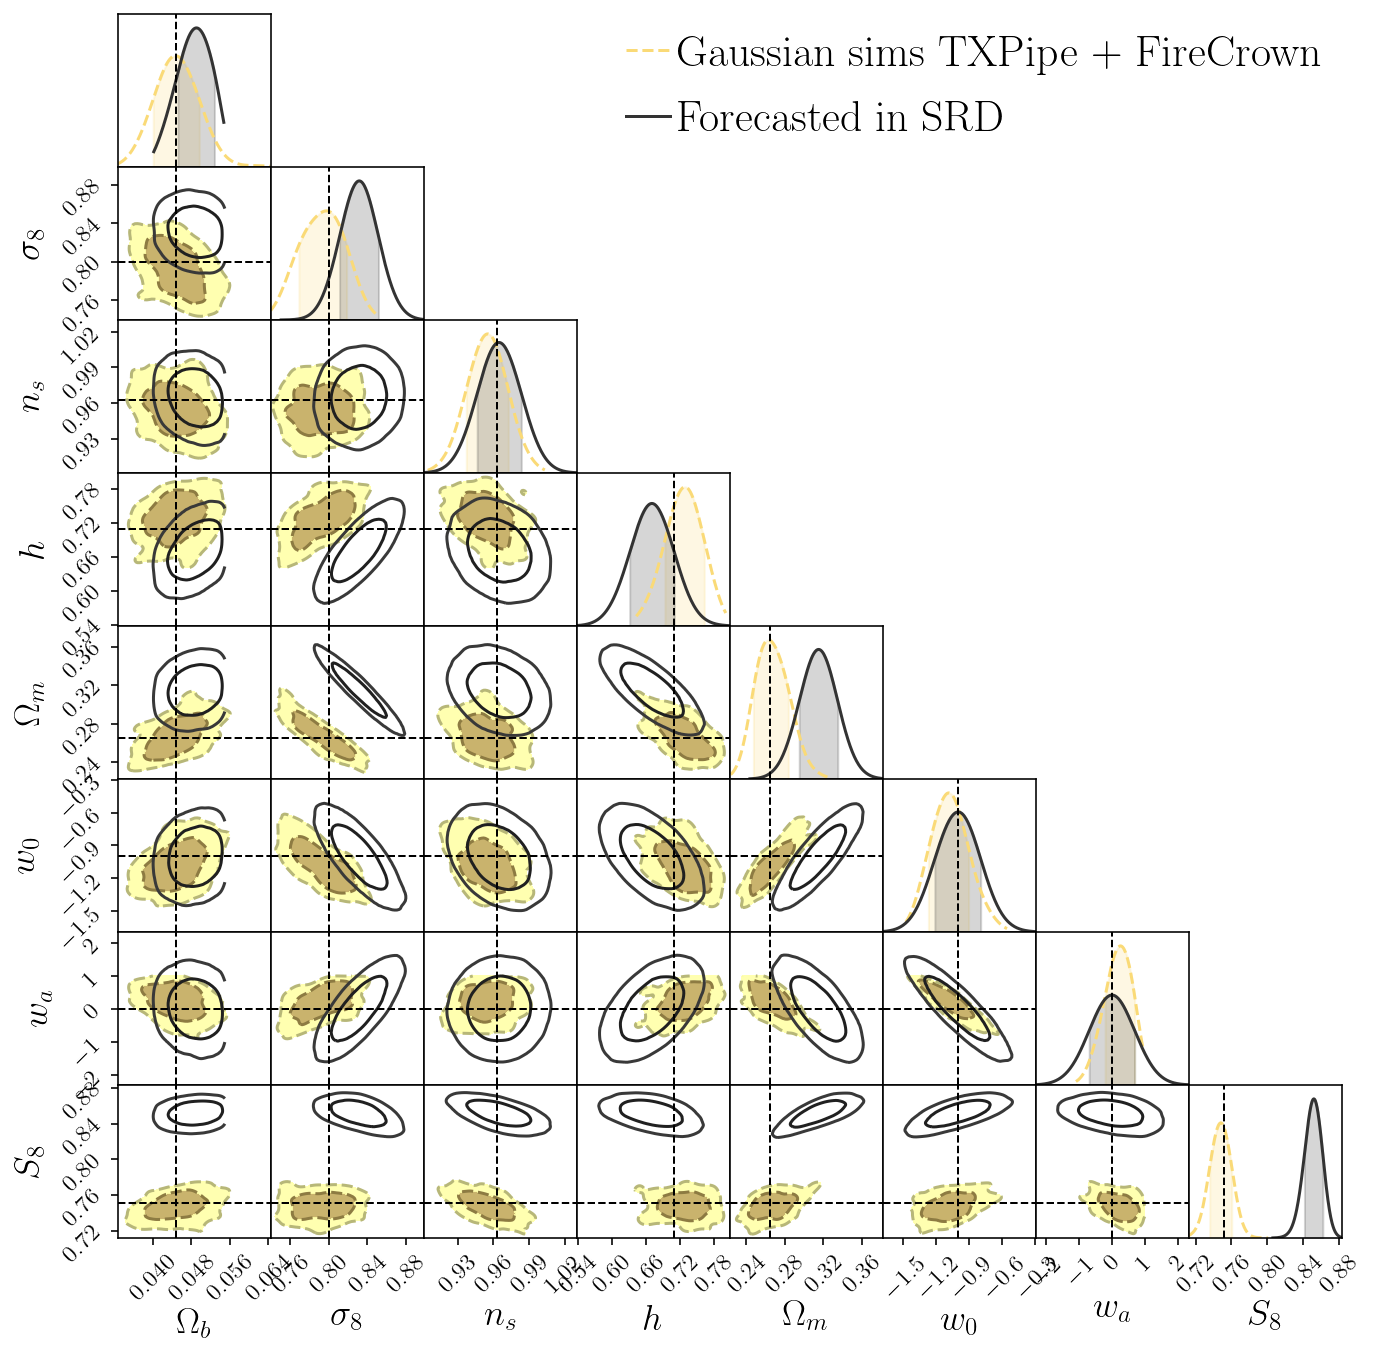

In [17]:
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_cosmopars_srd(chainfile_1, burnin)

c = ChainConsumer()
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=[ colors[3],'k', colors[2],  colors[2]],legend_kwargs={"fontsize": 22},
            legend_color_text=False, tick_font_size=12, label_font_size=18, linewidths=[ 1.5, 1.5,1.5, 1.5, 1], linestyles=["--", "-","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(5,5), truth=cosmo_truths)
fig.set_size_inches(5. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d.png'%(name_plots, burnin), tight_layout=True, dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d.pdf'%(name_plots, burnin), tight_layout=True)

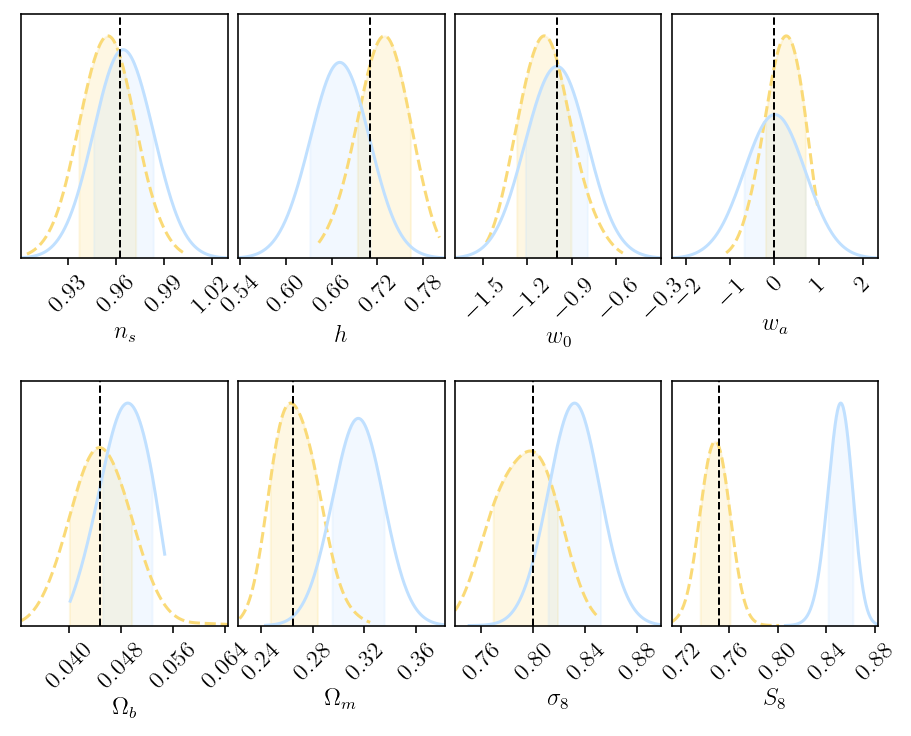

In [67]:
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']

cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo1 = get_cosmopars_srd(chainfile_1, burnin)

c = ChainConsumer()
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, False,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=[ colors[3], colors[2],  colors[0]],legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5, 1.5,1.5, 1.5, 1], linestyles=["--", "-","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.pdf'%(name_plots, burnin), bbox_inches="tight")

[3, 1, 6, 7, 2, 0, 30]
\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		DES Y3 & $0.937^{+0.064}_{-0.052}$ & $0.643^{+0.098}_{-0.080}$ & $-0.72^{+0.34}_{-0.39}$ & $-0.9\pm 1.3$ & $0.044^{+0.012}_{-0.010}$ & $0.345^{+0.051}_{-0.053}$ & $0.731^{+0.062}_{-0.058}$ & $0.786^{+0.029}_{-0.030}$ \\ 
		Gaussian sims TXPipe + FireCrown & $0.955^{+0.017}_{-0.018}$ & $0.729^{+0.034}_{-0.035}$ & $-1.09\pm 0.18$ & $0.27^{+0.43}_{-0.47}$ & $\left( 44.7^{+5.0}_{-4.6} \right) \times 10^{-3}$ & $0.263^{+0.021}_{-0.016}$ & $0.798^{+0.021}_{-0.029}$ & $0.748\pm 0.012$ \\ 
		Forecasted in SRD & $0.964^{+0.019}_{-0.018}$ & $0.670^{+0.040}_{-0.039}$ & $-1.00\pm 0.21$ & $0.00\pm 0.69$ & $\left( 49.1\pm 3.8 \right) \times 10^{-3}$ & $0.315\pm 0.020$ & $0.831\pm 0.020$ & $0.852\pm 0.010$ \\ 
		\hline
    \end{tabular}
\end{table}


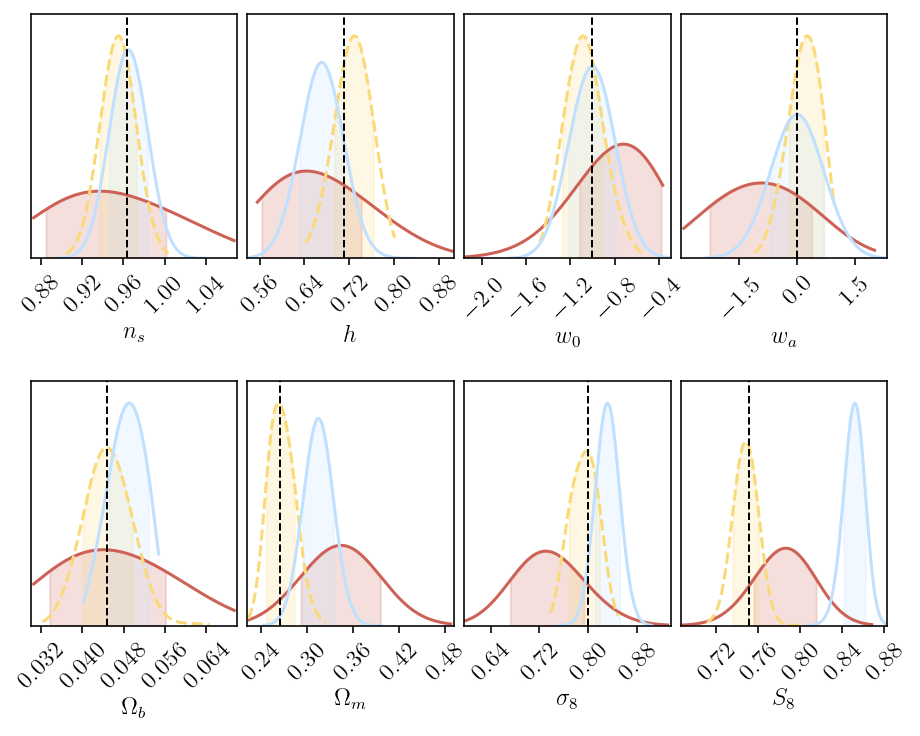

In [88]:
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']


cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']

def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars

cosmo1 = get_cosmopars_srd(chainfile_1, burnin)
cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo2 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)

c = ChainConsumer()
c.add_chain(cosmo2, parameters=cosmo_names, name=name_2, weights= chain_2[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)


def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, True, True,False,False,False,False, False], shade_alpha=[0.4, 0.5, 0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=[ "E5E4E2", "#D98880",colors[3], colors[2],  colors[0]],legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=[":", "-", "--", "-","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.pdf'%(name_plots, burnin), bbox_inches="tight")

[3, 1, 6, 7, 2, 0, 30]
\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		Prior analytic & $0.968^{+0.086}_{-0.091}$ & $0.715^{+0.066}_{-0.074}$ & $-1.05^{+0.90}_{-0.85}$ & $0.1^{+2.1}_{-2.4}$ & $\left( 44.8^{+6.4}_{-6.6} \right) \times 10^{-3}$ & -- & -- & -- \\ 
		Prior (for this work) & $0.964^{+0.075}_{-0.074}$ & $0.714^{+0.055}_{-0.050}$ & $-1.11^{+0.49}_{-0.52}$ & $-0.37^{+0.86}_{-0.98}$ & $\left( 44.7^{+7.9}_{-7.7} \right) \times 10^{-3}$ & $0.230^{+0.081}_{-0.088}$ & $0.72^{+0.31}_{-0.33}$ & $0.60^{+0.38}_{-0.37}$ \\ 
		$\textsc{CosmoDC2}$ & $1.000^{+0.049}_{-0.051}$ & $0.692^{+0.050}_{-0.039}$ & $-0.85^{+0.30}_{-0.31}$ & $-0.52^{+0.75}_{-0.86}$ & $\left( 44.7^{+6.2}_{-6.8} \right) \times 10^{-3}$ & $0.295^{+0.024}_{-0.031}$ & $0.750^{+0.036}_{-0.034}$ & $0.741^{+0.020}_{-0.022}$ \\ 
		DES Y3 & $0.937^{+0.064}_{-

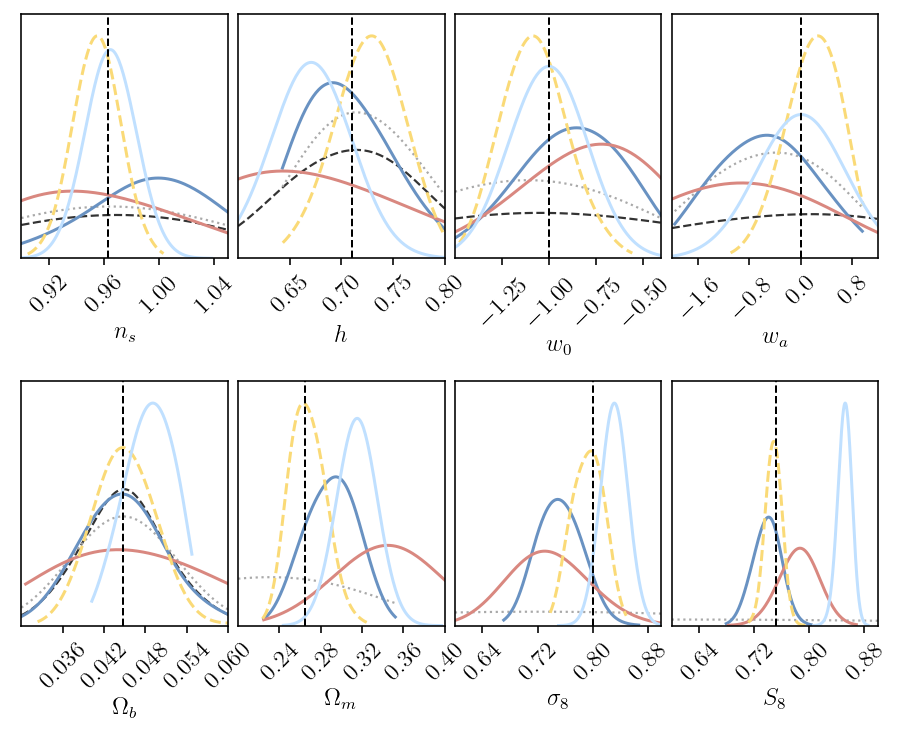

In [136]:
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']


cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']

def get_chain(filename, list_vars, chain):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    chain_ind = chain[:,indices]
    mask_nans = ~np.isnan(chain_ind.T[-1])
    chain_ind_no_nans = chain_4[:,indices][mask_nans]
    return chain_ind_no_nans

def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars


widths = np.array([0.08,0.063,0.8, 2.,0.006])
prior = np.random.multivariate_normal(cosmo_truths[:5],np.diagflat(widths**2),1000)

cosmo4 = get_chain(chainfile_4, cosmo_parnames, chain_4) # it has some nans in omega_m
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo1 = get_cosmopars_srd(chainfile_1, burnin)
cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo2 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)


c = ChainConsumer()
c.add_chain(prior, parameters=cosmo_names[:5], name="Prior analytic")
c.add_chain(cosmo4, parameters=cosmo_names, name=name_4)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)
c.add_chain(cosmo2, parameters=cosmo_names, name=name_2, weights= chain_2[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[1.,3.,3.,3.,3.0,3.,3.,1,1], shade=[True, True, True,False,False,False,False, False], shade_alpha=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ "k", "#A9A9A9", colors[1],"#D98880",colors[3], colors[2],  ],legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=["--", ":", "-", "-", "--","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot_distributions(figsize=(4,2.), truth=cosmo_truths, extents=[(0.9, 1.05), (0.6, 0.8), (-1.5, -0.4), (-2, 1.2),(0.03, 0.06), (0.20, 0.4), (0.6, 0.9), (0.6, 0.9) ])
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d_1D.pdf'%(name_plots, burnin), bbox_inches="tight")

[3, 1, 6, 7, 2, 0, 30]
\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		Prior (for this work) & $0.966\pm 0.083$ & $0.718^{+0.057}_{-0.056}$ & $-1.12^{+0.54}_{-0.55}$ & $-0.47\pm 0.99$ & $\left( 45.4^{+9.8}_{-9.9} \right) \times 10^{-3}$ & $0.227^{+0.087}_{-0.089}$ & $0.70^{+0.39}_{-0.40}$ & $0.61^{+0.44}_{-0.43}$ \\ 
		$\textsc{CosmoDC2}$ & $1.000^{+0.049}_{-0.051}$ & $0.692^{+0.050}_{-0.039}$ & $-0.85^{+0.30}_{-0.31}$ & $-0.52^{+0.75}_{-0.86}$ & $\left( 44.7^{+6.2}_{-6.8} \right) \times 10^{-3}$ & $0.295^{+0.024}_{-0.031}$ & $0.750^{+0.036}_{-0.034}$ & $0.741^{+0.020}_{-0.022}$ \\ 
		DES Y3 & $0.937^{+0.064}_{-0.052}$ & $0.643^{+0.098}_{-0.080}$ & $-0.72^{+0.34}_{-0.39}$ & $-0.9\pm 1.3$ & $0.044^{+0.012}_{-0.010}$ & $0.345^{+0.051}_{-0.053}$ & $0.731^{+0.062}_{-0.058}$ & $0.786^{+0.029}_{-0.030}$ \\ 
		Gaussian sims 

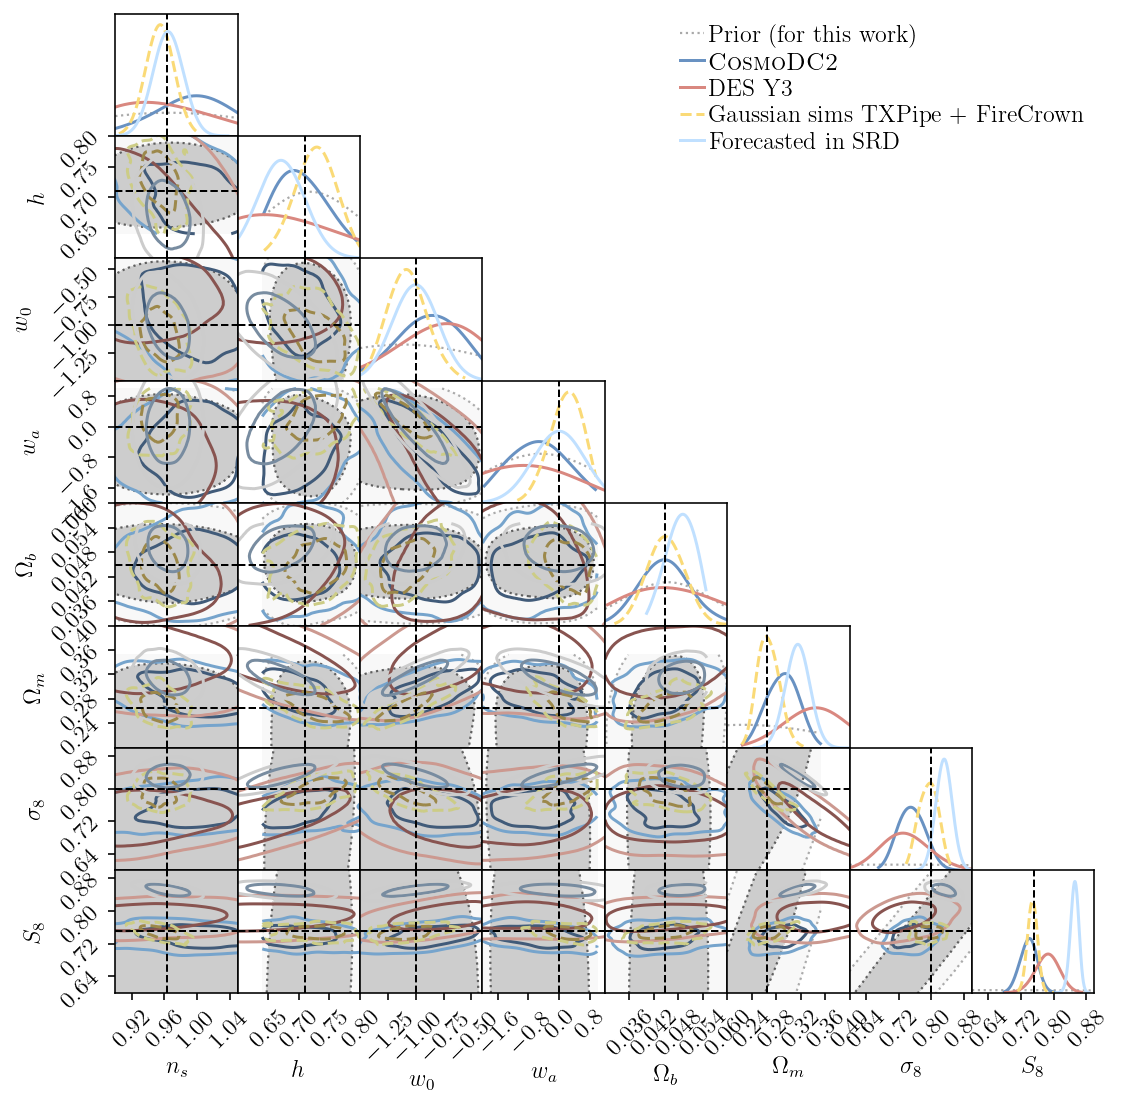

In [129]:
# With EMCEE there are no weights
# Cosmo parameters
# FireCrown names
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']


cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']

def get_chain(filename, list_vars, chain):
    """
    Function to obtain the index in a multinest chain from certain variables.
    """
    indices = []
    names = get_names(filename)
    for var in list_vars:
        indices.extend([i for i,n in enumerate(names) if var==n])
    #return indices, names[indices]
    chain_ind = chain[:,indices]
    mask_nans = ~np.isnan(chain_ind.T[-1])
    chain_ind_no_nans = chain_4[:,indices][mask_nans]
    return chain_ind_no_nans

def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars

cosmo4 = get_chain(chainfile_4, cosmo_parnames, chain_4) # it has some nans in omega_m
cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo1 = get_cosmopars_srd(chainfile_1, burnin)
cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo2 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)

#cosmo1 = get_indices(chainfile_1, cosmo_parnames_srd)

c = ChainConsumer()

c.add_chain(cosmo4, parameters=cosmo_names, name=name_4)
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)
c.add_chain(cosmo2, parameters=cosmo_names, name=name_2, weights= chain_2[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,3.,1,1], shade=[True, False, False,False,False,False,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=False,colors=[ "#A9A9A9", colors[1],"#D98880",colors[3], colors[2],  ],legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[1.1, 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=[":", "-", "-", "--","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(5,5.), truth=cosmo_truths, extents=[(0.9, 1.05), (0.6, 0.8), (-1.5, -0.4), (-2, 1.2),(0.03, 0.06), (0.20, 0.4), (0.6, 0.9), (0.6, 0.9) ])
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d.pdf'%(name_plots, burnin), bbox_inches="tight")

[3, 1, 6, 7, 2, 0, 30]
\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{ccccccccc}
        \hline
		Model & $n_s$ & $h$ & $w_0$ & $w_a$ & $\Omega_b$ & $\Omega_m$ & $\sigma_8$ & $S_8$ \\ 
		\hline
		$\textsc{CosmoDC2}$ & $1.000^{+0.049}_{-0.051}$ & $0.692^{+0.050}_{-0.039}$ & $-0.85^{+0.30}_{-0.31}$ & $-0.52^{+0.75}_{-0.86}$ & $\left( 44.7^{+6.2}_{-6.8} \right) \times 10^{-3}$ & $0.295^{+0.024}_{-0.031}$ & $0.750^{+0.036}_{-0.034}$ & $0.741^{+0.020}_{-0.022}$ \\ 
		DES Y3 & $0.937^{+0.064}_{-0.052}$ & $0.643^{+0.098}_{-0.080}$ & $-0.72^{+0.34}_{-0.39}$ & $-0.9\pm 1.3$ & $0.044^{+0.012}_{-0.010}$ & $0.345^{+0.051}_{-0.053}$ & $0.731^{+0.062}_{-0.058}$ & $0.786^{+0.029}_{-0.030}$ \\ 
		Gaussian sims TXPipe + FireCrown & $0.955^{+0.017}_{-0.018}$ & $0.729^{+0.034}_{-0.035}$ & $-1.09\pm 0.18$ & $0.27^{+0.43}_{-0.47}$ & $\left( 44.7^{+5.0}_{-4.6} \right) \times 10^{-3}$ & $0.263^{+0.021}_{-0.016}$ & $0.798^{+0.021}_{-0.029}$ & $0.748\pm 0.012$ \\ 


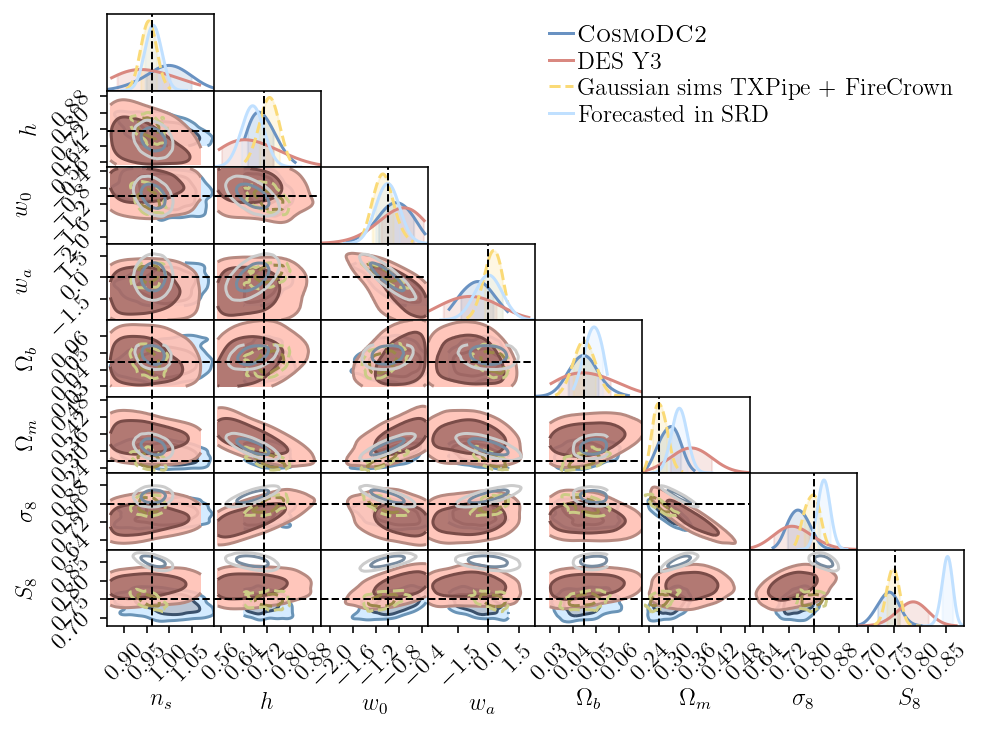

In [96]:
# With EMCEE there are no weights
# Cosmo parameters
# FireCrown names
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']


cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']

def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars

cosmo3 = get_indices(chainfile_3, cosmo_parnames)
cosmo1 = get_cosmopars_srd(chainfile_1, burnin)
cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo2 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)

#cosmo1 = get_indices(chainfile_1, cosmo_parnames_srd)

c = ChainConsumer()
c.add_chain(chain_3[burnin:,cosmo3], parameters=cosmo_names, name=name_3)
c.add_chain(cosmo2, parameters=cosmo_names, name=name_2, weights= chain_2[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, True,False,False,False,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=[ colors[1],"#D98880",colors[3], colors[2],  ],legend_kwargs={"fontsize": 12, "loc":'best'},
            legend_color_text=False, tick_font_size=12, label_font_size=12, linewidths=[ 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=["-", "-", "--","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
table = c.analysis.get_latex_table()
print(table)

fig = c.plotter.plot(figsize=(5,5), truth=cosmo_truths)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d.pdf'%(name_plots, burnin), bbox_inches="tight")

[3, 1, 6, 7, 2, 0, 30]


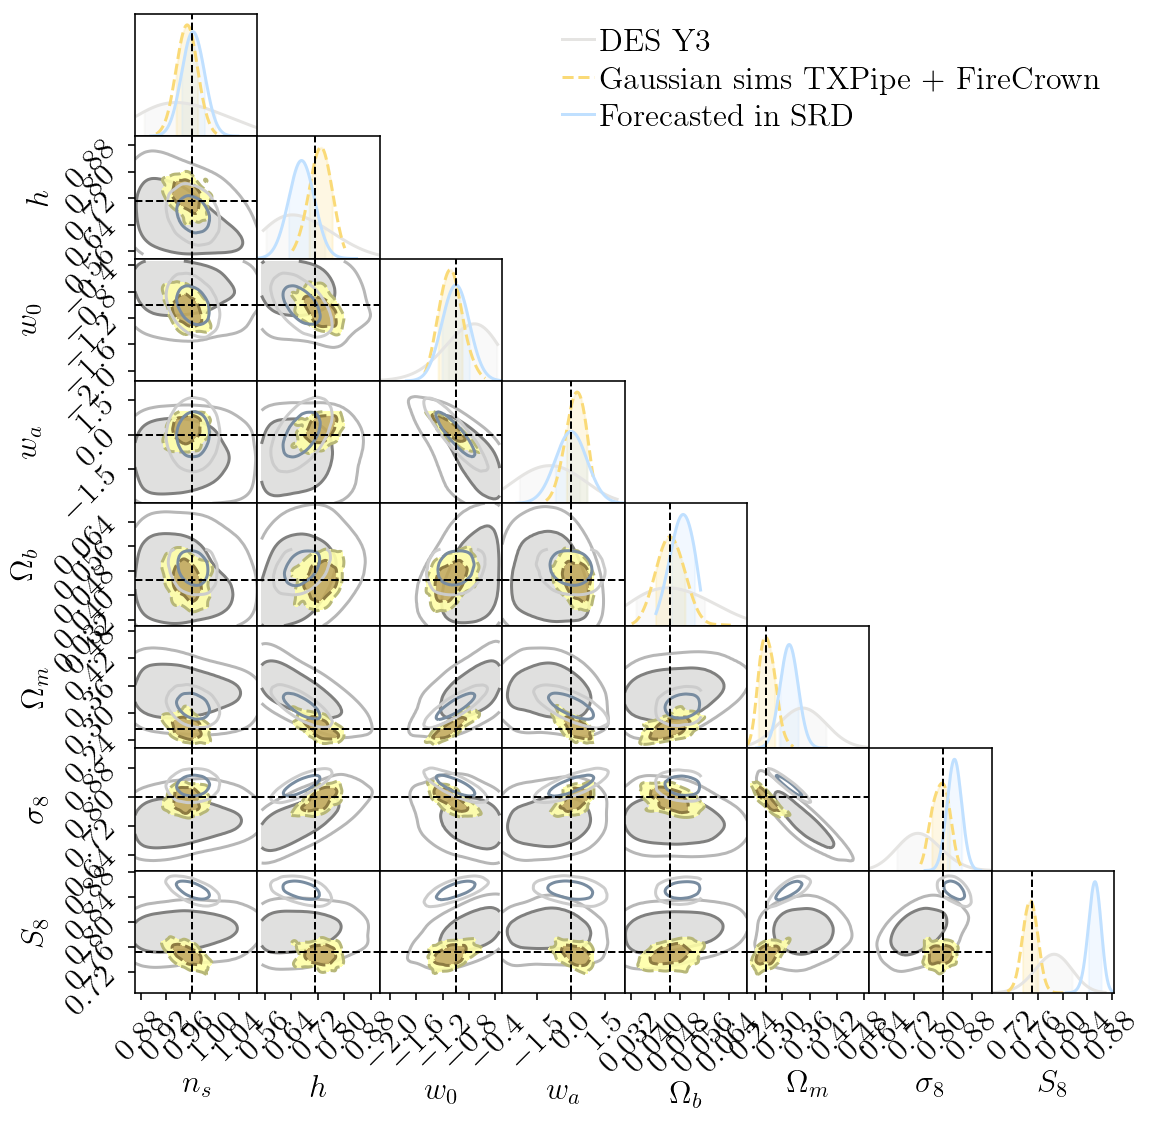

In [87]:
# With EMCEE there are no weights
# Cosmo parameters
# FireCrown names
burnin = 150000
cosmo_parnames = [ 'cosmological_parametersn_s',  'cosmological_parametersh0',
                  'cosmological_parametersw','cosmological_parameterswa',
                  'cosmological_parametersomega_b',  'COSMOLOGICAL_PARAMETERSOMEGA_M',
                  'COSMOLOGICAL_PARAMETERSSIGMA_8', 'COSMOLOGICAL_PARAMETERSS_8']
cosmo_names = ['$n_s$','$h$',  '$w_0$', '$w_a$', '$\Omega_b$','$\Omega_m$','$\sigma_8$','$S_8$']
cosmo_truths = [ 9.630000e-01,   0.71,  -1, 0, 4.479270e-02, 2.647887e-01,8.000000e-01,0.7515866949]
cosmo_parnames_srd = ['n_s','h0','w0', 'wa', 'omega_b','omega_m','sigma_8']


cosmo_parnamesy3=['cosmological_parametersn_s', 'cosmological_parametersh0',
                  'cosmological_parametersw', 'cosmological_parameterswa',
                  'cosmological_parametersomega_b','cosmological_parametersomega_m', 
                 'COSMOLOGICAL_PARAMETERSSIGMA_8']

def get_cosmoparsy3(chainfile, cosmo_parnamesy3):
    chain = np.loadtxt(chainfile)
    indices = get_indices(chainfile, cosmo_parnamesy3)
    print(indices)
    omega_m =chain[:,indices[-2]]
    sigma_8 = chain[:,indices[-1]]
    s8 = sigma_8*(omega_m/0.3)**(0.5)
    cosmo_pars = chain[:,indices].T
    # add s8 to the array
    cosmo_pars = np.vstack((cosmo_pars, [s8])).T
    
    return cosmo_pars

cosmo1 = get_cosmopars_srd(chainfile_1, burnin)
cosmo0 = get_indices(chainfile_0, cosmo_parnames)
cosmo2 = get_cosmoparsy3(chainfile_2, cosmo_parnamesy3)
#cosmo1 = get_indices(chainfile_1, cosmo_parnames_srd)

c = ChainConsumer()
c.add_chain(cosmo2, parameters=cosmo_names, name=name_2, weights= chain_2[:,-1])
c.add_chain(chain_0[burnin:,cosmo0], parameters=cosmo_names, name=name_0)
c.add_chain(cosmo1, parameters=cosmo_names, name=name_1)

def call_configure(c):
    c.configure(kde=[3.,3.,3.,3.,3.0,1,1], shade=[True, True,False,False,False,False, False], shade_alpha=[0.4, 0.9, 0.9, 0.9, 0.9], bar_shade=True,colors=[ "#E5E4E2",colors[3], colors[2],  colors[0]],legend_kwargs={"fontsize": 16, "loc":'best'},
            legend_color_text=False, tick_font_size=16, label_font_size=16, linewidths=[ 1.5, 1.5, 1.5,1.5, 1.5, 1], linestyles=["-", "--", "-","-", "--","-", "-", "--",":"])
    return c

c = call_configure(c)
#table = c.analysis.get_latex_table()
#print(table)

fig = c.plotter.plot(figsize=(5,5.), truth=cosmo_truths)
fig.set_size_inches(3. + fig.get_size_inches())
fig.savefig(dir[:-7] + 'plots/%s_%d.png'%(name_plots, burnin),  bbox_inches="tight", dpi=300)
fig.savefig(dir[:-7] + 'plots/%s_%d.pdf'%(name_plots, burnin), bbox_inches="tight")